# Makemore: Activation, Gradients, BatchNorm

- [Andrej Karpathy YouTube](https://www.youtube.com/watch?v=P6sfmUTpUmc&ab_channel=AndrejKarpathy)

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

In [4]:
def load_data(file_path: str) -> list[str]:
    """Load text data from a file and return as a list of strings."""

    with open(file_path, "r") as f:
        # Read all the lines as a list
        data: list[str] = f.read().splitlines()

    return data

In [5]:
# Load Data
fp: str = "../../../data/names.txt"
names: list[str] = load_data(file_path=fp)

names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

### Build Vocabulary Of Characters And Mappings

In [6]:
special_token: str = "."
characters: list[str] = sorted(set("".join(names)))
# Add the special token to the beginning of the list.
characters.insert(0, special_token)
n_chars: int = len(characters)

# Convert text to numbers.
text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(characters)}
# Convert numbers to text
num_to_text: dict[int, str] = {idx: text for text, idx in text_to_num.items()}

In [7]:
from torch.utils.data import random_split, TensorDataset, Dataset
from sklearn.model_selection import train_test_split


def build_dataset(
    names: list[str],
    special_token: str = ".",
    block_size: int = 3,
    print_info: bool = False,
) -> tuple[Tensor, Tensor]:
    """
    Builds a dataset of name sequences and their corresponding character indices.

    Args:
        names (list[str]): A list of names to build the dataset from.
        special_token (str, optional): A special token to append to the end of each name. Defaults to ".".
        block_size (int, optional): The size of the context window for each input sequence. Defaults to 3.
        print_info (bool, optional): Whether to print information about the dataset generation. Defaults to False.

    Returns:
        tuple[Tensor, Tensor]: A tuple containing the input sequences (X) and their corresponding target indices (Y).
    """
    X, Y = [], []

    for w in names:
        if print_info:
            print(w)
        context: list[str] = [0] * block_size

        for ch in w + special_token:
            ix: int = text_to_num.get(ch)
            X.append(context)
            Y.append(ix)

            if print_info:
                print(
                    f"{''.join([num_to_text.get(i) for i in context])} ---> {num_to_text.get(ix)}"
                )

            # Crop and append, like a rolling window
            context = context[1:] + [ix]

    X: Tensor = torch.tensor(X)
    Y: Tensor = torch.tensor(Y)
    print(f"\n{X.shape=}, {Y.shape=}")
    return (X, Y)


def split_data_into_train_dev_test(
    data: Tensor | Dataset, test_size: float = 0.05, dev_size: float = 0.1, seed=42
) -> tuple[Tensor, ...]:
    """
    Splits a given PyTorch tensor `data` into training, development, and test sets.

    Params:
    -------
        data (torch.Tensor): The input tensor to be split.
        test_size (float, optional): The fraction of the data to use for the test set. Defaults to 0.2.
        dev_size (float, optional): The fraction of the data to use for the development set. Defaults to 0.1.
        seed (int, optional): The random seed to use for reproducibility. Defaults to 42.

    Returns:
    --------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The training, development, and test sets as PyTorch tensors.
    """
    if isinstance(data, Tensor):
        X_train, X_test = train_test_split(data, test_size=test_size, random_state=seed)
        X_train, X_dev = train_test_split(
            X_train, test_size=dev_size, random_state=seed
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test)
    if isinstance(data, Dataset):
        X_train, X_test, y_train, y_test = train_test_split(
            data.data,
            data.targets,
            test_size=test_size,
            random_state=seed,
            stratify=data.targets,
        )
        X_train, X_dev, y_train, y_dev = train_test_split(
            X_train, y_train, test_size=dev_size, random_state=seed, stratify=y_train
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test, y_train, y_dev, y_test)

    print(f"{X_train.shape=}; {X_dev.shape=}; {X_test.shape=}")

    return result


class MyDataset(Dataset):
    def __init__(self, data: Tensor, targets: Tensor) -> None:
        self.data = data
        self.targets = targets

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(data.shape={self.data.shape}, "
            f"target.shape={self.targets.shape=})"
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

In [8]:
X, y = build_dataset(names=names[:5], block_size=3, print_info=True)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .

X.shape=torch.Size([32, 3]), Y.shape=torch.Size([32])


### MLP

### Benefits of Properly Initializing Neurons

- Faster convergence: Proper initialization helps the learning algorithm find good solutions quicker. This can significantly reduce training time.

- Avoids vanishing/exploding gradients:  Certain initialization schemes can cause gradients to either vanish or explode as they propagate through the network. Vanishing gradients make it difficult for the network to learn anything, while exploding gradients can lead to unstable training. Proper initialization helps avoid these issues.

- Breaks symmetry and promotes diversity:  If all the weights in a layer are initialized the same (e.g., all zeros), the neurons in that layer will all be learning the same thing. Proper initialization, typically with random values, ensures that each neuron has a unique starting point and is more likely to learn different features from the input data.

- Improves overall model performance: By addressing the above issues, proper initialization can lead to models that achieve better accuracy and generalization on unseen data.

In [9]:
X, y = build_dataset(names=names, block_size=3, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)


X.shape=torch.Size([228152, 3]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 3]); X_dev.shape=torch.Size([21675, 3]); X_test.shape=torch.Size([11408, 3])


In [10]:
g = torch.Generator().manual_seed(5)

# Parameters
emb_dim: int = 10  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 300  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 100_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g)
W1: Tensor = torch.randn((M, n_nodes), generator=g)
b1: Tensor = torch.randn(n_nodes, generator=g)
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g)  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g)  # (27,)
print(f"{C.shape = }")
parameters: list[Tensor] = [C, W1, b1, W2, b2]
n_parameters: int = sum([p.numel() for p in parameters])

# Require gradients to be true
for p in parameters:
    p.requires_grad = True

print(f"{n_parameters = :,}")

C.shape = torch.Size([27, 10])
n_parameters = 17,697


In [11]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))

    # Step 1: Build an embedding lookup table
    # Embed the input
    emb: Tensor = F.one_hot(X_train[idx], num_classes=n_chars).float() @ C

    # Forward pass
    # Step 2: Build The Hidden Layer
    # Reshape the input to match the shape of the weight matrix
    h: Tensor = emb.view(-1, M) @ W1 + b1
    # Apply a non-linearity
    h = torch.tanh(h)

    # Step 3: Output Layer
    logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

    # Calculate the loss: Negative log likelihood loss
    loss: Tensor = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    # Reset gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    if epoch > 70_000:
        learning_rate = 0.01
    elif epoch > 80_000:
        learning_rate = 0.001

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch) % 10_000 == 0:
        print(f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.4f}")

Epoch: 0/100000 | Loss: 27.3056
Epoch: 10000/100000 | Loss: 2.5583
Epoch: 20000/100000 | Loss: 2.6481
Epoch: 30000/100000 | Loss: 2.2113
Epoch: 40000/100000 | Loss: 2.6910
Epoch: 50000/100000 | Loss: 3.0252
Epoch: 60000/100000 | Loss: 2.7857
Epoch: 70000/100000 | Loss: 1.9589
Epoch: 80000/100000 | Loss: 2.2128
Epoch: 90000/100000 | Loss: 2.1718


In [12]:
def calculate_loss(X: Tensor, y: Tensor, num_classes: int, training: True) -> Tensor:
    """
    Calculates the loss for the given input data and number of classes.

    Args:
        data (torch.Tensor): The input data tensor.
        num_classes (int): The number of classes.

    Returns:
        torch.Tensor: The calculated loss.
    """
    with torch.no_grad():
        input: Tensor = F.one_hot(X, num_classes=num_classes).float()
        emb: Tensor = torch.matmul(input, C)
        h: Tensor = torch.matmul(emb.view(-1, M), W1) + b1
        h = torch.tanh(h)
        logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

        loss: Tensor = F.cross_entropy(logits, y)
        result: str = (
            f"Training loss: {loss:.4f}" if training else f"Validation loss: {loss:.4f}"
        )
        print(result)

        return loss

In [13]:
calculate_loss(X=X_train, y=y_train, num_classes=n_chars, training=True)
calculate_loss(X=X_dev, y=y_dev, num_classes=n_chars, training=False)

Training loss: 2.1623
Validation loss: 2.2082


tensor(2.2082)

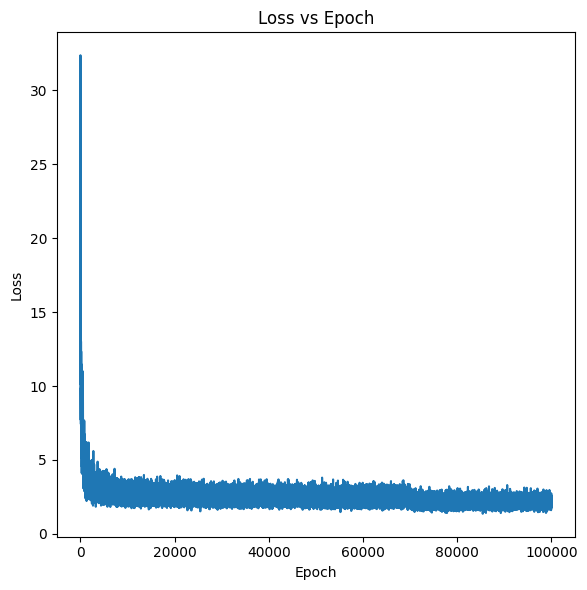

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))  # Create figure and axes
ax.plot(torch.arange(epochs), losses_all)  # Plot the data
ax.set(xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch")  # Add labels
plt.tight_layout()
plt.show()

#### Comment:

- From the plot, we can see that the initial loss is way to high compared to the subsequent losses. i.e. 31.67, 2.8, etc.
- This is because of the way the modl weights were initialized.
- To solve this problem, we can:
  1. Initialize the weights with numbers that are very close to zero.
  2. Initialize the bias with zeros.
- This makes the loss very close to the subsequent losses.
- e.g. if the prob of selecting a char at random is 1 / n_chars, the negative log likelihood is:
$$  loss = -1 * log(\frac{1}{n_{chars}})  $$

- The plot of the loss vs epochs should `not` have a golf curve.

In [15]:
-1 * torch.tensor([1 / n_chars]).log()

tensor([3.2958])

In [16]:
X, y = build_dataset(names=names, block_size=3, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)


X.shape=torch.Size([228152, 3]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 3]); X_dev.shape=torch.Size([21675, 3]); X_test.shape=torch.Size([11408, 3])


In [17]:
g = torch.Generator().manual_seed(5)

# Parameters
emb_dim: int = 10  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 300  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 100_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g) * 0.01
W1: Tensor = torch.randn((M, n_nodes), generator=g) * 0.01
b1: Tensor = torch.randn(n_nodes, generator=g) * 0.01
# Initialize the weights and biases with very small random values.
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g) * 0.01  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g) * 0  # (27,)
print(f"{C.shape = }")
parameters: list[Tensor] = [C, W1, b1, W2, b2]
n_parameters: int = sum([p.nelement() for p in parameters])

# Require gradients to be true
for p in parameters:
    p.requires_grad = True

print(f"{n_parameters = :,}")

C.shape = torch.Size([27, 10])
n_parameters = 17,697


In [18]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))

    # Step 1: Build an embedding lookup table
    # Embed the input
    emb: Tensor = F.one_hot(X_train[idx], num_classes=n_chars).float() @ C

    # Forward pass
    # Step 2: Build The Hidden Layer
    # Reshape the input to match the shape of the weight matrix
    h: Tensor = emb.view(-1, M) @ W1 + b1
    # Apply a non-linearity
    h = torch.tanh(h)

    # Step 3: Output Layer
    logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

    # Calculate the loss: Negative log likelihood loss
    loss: Tensor = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    # Reset gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    if epoch > 70_000:
        learning_rate = 0.01
    elif epoch > 80_000:
        learning_rate = 0.001

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch) % 10_000 == 0:
        print(f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.4f}")

Epoch: 0/100000 | Loss: 3.2954
Epoch: 10000/100000 | Loss: 2.0960
Epoch: 20000/100000 | Loss: 2.4632
Epoch: 30000/100000 | Loss: 2.1231
Epoch: 40000/100000 | Loss: 1.8295
Epoch: 50000/100000 | Loss: 2.0488
Epoch: 60000/100000 | Loss: 2.0262
Epoch: 70000/100000 | Loss: 1.5137
Epoch: 80000/100000 | Loss: 2.2661
Epoch: 90000/100000 | Loss: 1.9610


In [19]:
calculate_loss(X=X_train, y=y_train, num_classes=n_chars, training=True)
calculate_loss(X=X_dev, y=y_dev, num_classes=n_chars, training=False)

Training loss: 2.1676
Validation loss: 2.1906


tensor(2.1906)

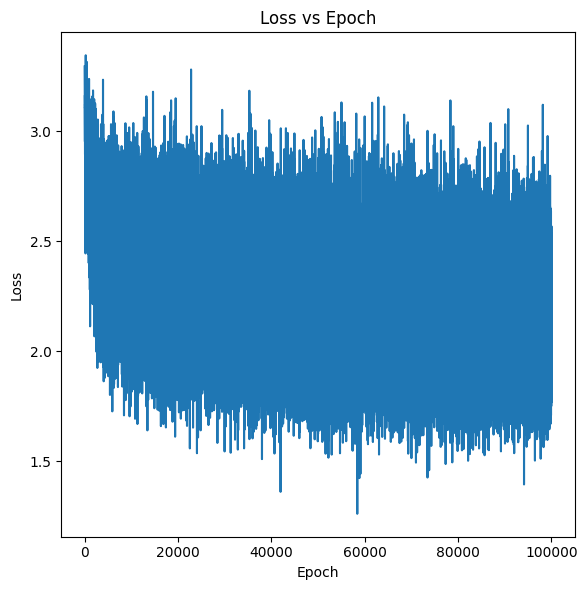

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))  # Create figure and axes
ax.plot(torch.arange(epochs), losses_all)  # Plot the data
ax.set(xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch")  # Add labels
plt.tight_layout()
plt.show()

In [21]:
h.shape

torch.Size([32, 300])

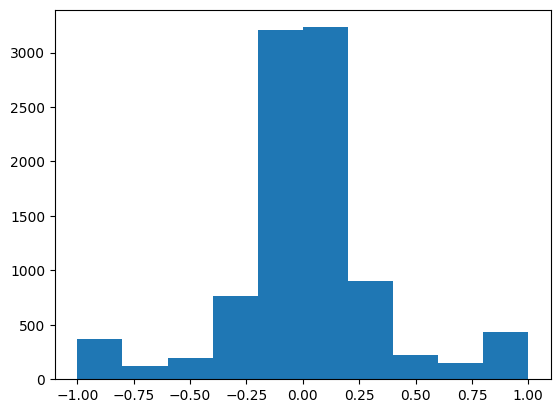

In [22]:
# Convert to a 1-D tensor
plt.hist(h.view(-1).tolist())
plt.show()

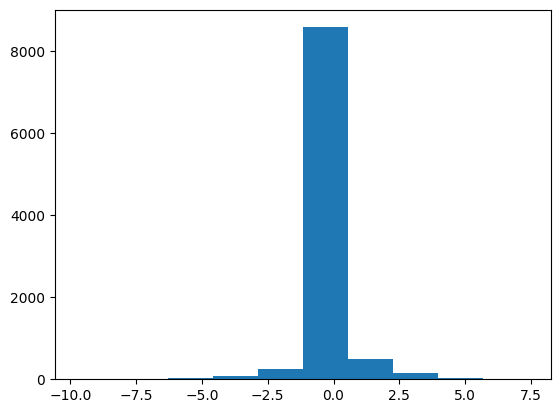

In [23]:
h_before_tanh: Tensor = emb.view(-1, M) @ W1 + b1
# Convert to a 1-D tensor
plt.hist(h_before_tanh.view(-1).tolist())
plt.show()

#### Comment

- For `h`, we can see that the activation function is strong. i.e. most values are between -1 and 1.
- For `h_before_tanh`, we can see that there's `NO` activation function and the values are normally distributed.

In [24]:
class Linear:
    """
    A linear layer implementation.

    This class implements a linear layer, which performs a linear transformation on the input tensor. It takes in the number
    of input features and output features, and optionally a bias term. The weights and biases are initialized randomly.

    The `__call__` method applies the linear transformation to the input tensor and returns the output tensor.

    The `parameters` method returns a list of the learnable parameters (weights and biases) of the layer.
    """

    def __init__(
        self, in_features: int, out_features: int, bias: bool = True, seed: int = 42
    ) -> None:
        self.in_features = in_features
        self.out_features = out_features
        self.weight = (
            torch.randn(in_features, out_features, generator=torch.manual_seed(seed))
            / in_features**0.5
        )
        self.bias = (
            torch.randn(out_features, generator=torch.manual_seed(seed))
            if bias
            else None
        )

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.in_features}, {self.out_features})"

    def __call__(self, x: Tensor) -> Tensor:
        self.output: Tensor = torch.matmul(x, self.weight)
        if self.bias is not None:
            self.output += self.bias
        return self.output

    def parameters(self) -> list[Tensor]:
        return [self.weight] + ([self.bias] if self.bias is not None else [])

In [25]:
l1 = Linear(in_features=10, out_features=20, bias=False)
print(l1)

x: Tensor = torch.randn((5, 10))
print(f"{x.shape = }")
l1(x)
print(f"{l1(x).shape = }")

Linear(10, 20)
x.shape = torch.Size([5, 10])
l1(x).shape = torch.Size([5, 20])


In [26]:
# Number of parameters in a model
[p.numel() for p in l1.parameters()][0]

200

### Batch Normalization

- Batch normalization (BatchNorm) tackles challenges in training deep neural networks.
- It standardizes activation values across mini-batches, making the learning process more stable.
- This allows for faster training, improved gradient flow, and reduced sensitivity to initialization.
- BatchNorm also acts as a regularizer, boosting overall network performance.

In [27]:
from typing import Any


class BatchNorm1d:
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: Tensor) -> Tensor:
        if self.training:
            # Calculate the batch mean and variance
            x_mean: Tensor = x.mean(dim=0, keepdim=True)
            x_var: Tensor = x.var(dim=0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        # Normalize the input
        x_hat: Tensor = (x - x_mean) / (x_var + self.eps).sqrt()
        self.output: Tensor = (self.gamma * x_hat) + self.beta

        if self.training:
            with torch.no_grad():
                # Update running mean and variance
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * x_mean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * x_var

        return self.output

    def parameters(self) -> list[Tensor]:
        return [self.gamma, self.beta]


class Tanh:
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"

    def __call__(self, x: Tensor) -> Tensor:
        self.output = torch.tanh(x)
        return self.output

    def parameters(self) -> list[Tensor]:
        return []

In [28]:
# Parameters
emb_dim: int = 10  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 300  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 100_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g) * 0.01  # Lookup table
W1: Tensor = torch.randn((M, n_nodes), generator=g) * 0.01
b1: Tensor = torch.randn(n_nodes, generator=g) * 0.01
# Initialize the weights and biases with very small random values.
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g) * 0.01  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g) * 0  # (27,)

layers: list[Any] = [
    Linear(in_features=M, out_features=n_nodes, bias=True),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_nodes, bias=True),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_nodes, bias=True),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_nodes, bias=True),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_nodes, bias=True),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_chars, bias=True),
]

with torch.no_grad():
    # Make last layer less confident
    layers[-1].weight *= 0.1
    # Apply gain to the other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # Scale the weights of all other linear layers by a gain factor.
            layer.weight *= 5 / 3

# Parameters Collection
parameters: list[Tensor] = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total params: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True

Total params: 378,897


In [29]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))
    # X, y batch
    Xb, yb = X_train[idx], y_train[idx]

    # Forward pass
    # Step 1: Calculate the embeddings
    emb: Tensor = F.one_hot(Xb, num_classes=n_chars).float() @ C
    x: Tensor = emb.view(emb.shape[0], -1)  # Concatenate the embeddings

    # Step 2: Build The Hidden Layer
    for layer in layers:
        x: Tensor = layer(x)  # Logits: Apply the linear layer
    loss: Tensor = F.cross_entropy(x, yb)

    # Backward pass
    for p in parameters:
        # Reset gradients
        p.grad = None
    loss.backward()

    # learning rate decay
    learning_rate: float = (
        0.1 if epoch < 70_000 else (0.01 if epoch < 80_000 else 0.001)
    )

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch) % 10_000 == 0:
        print(f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.4f}")

    if epoch >= 1_000:
        break  # AFTER_DEBUG: would take out obviously to run full optimization

Epoch: 0/100000 | Loss: 3.6539


In [30]:
def calculate_loss_upd(
    X: Tensor, y: Tensor, num_classes: int, training: True
) -> Tensor:
    """
    Calculates the loss for the given input data and number of classes.

    Args:
        data (torch.Tensor): The input data tensor.
        num_classes (int): The number of classes.

    Returns:
        torch.Tensor: The calculated loss.
    """
    # Set the training mode to False
    for layer in layers:
        if hasattr(layer, "training"):
            layer.training = False

    with torch.no_grad():
        input: Tensor = F.one_hot(X, num_classes=num_classes).float() @ C
        x: Tensor = input.view(input.shape[0], -1)

        for layer in layers:
            x: Tensor = layer(x)  # Logits: Apply the linear layer
        loss: Tensor = F.cross_entropy(x, y)
        result: str = (
            f"Training loss: {loss:.4f}" if training else f"Validation loss: {loss:.4f}"
        )
        print(result)

        return loss

In [31]:
calculate_loss_upd(X=X_train, y=y_train, num_classes=n_chars, training=True)
calculate_loss_upd(X=X_dev, y=y_dev, num_classes=n_chars, training=False)

Training loss: 2.5509
Validation loss: 2.5561


tensor(2.5561)

### Interpretation Of The Chart

- The chart shows the distribution of activations for each `Tanh` layer.
- Each line corresponds to the activation distribution of a different layer.
- The x-axis represents the range of activation values.
- The y-axis represents the density of activations (i.e., how frequently certain activation values occur).

<br>

- Layer-wise Activation Distribution:
  - The plot shows how the activation values are distributed across different layers.
  - This can provide insights into how the neural network is learning and where activations might be saturated.

- Saturation:
  - Layers with higher saturation percentages have more activations near the extremes (±1).
  - This can be a sign of vanishing gradients in deeper layers, especially with the Tanh activation function.

- Mean and Standard Deviation:
  - The statistics printed for each layer help understand the central tendency and spread of activation values, which is crucial for diagnosing issues like exploding or vanishing gradients.

layer 1 (Tanh()): mean +0.04, std 0.66, saturated: 5.49%
layer 3 (Tanh()): mean +0.01, std 0.69, saturated: 12.65%
layer 5 (Tanh()): mean +0.03, std 0.77, saturated: 19.84%
layer 7 (Tanh()): mean +0.00, std 0.81, saturated: 26.07%
layer 9 (Tanh()): mean +0.01, std 0.56, saturated: 7.79%


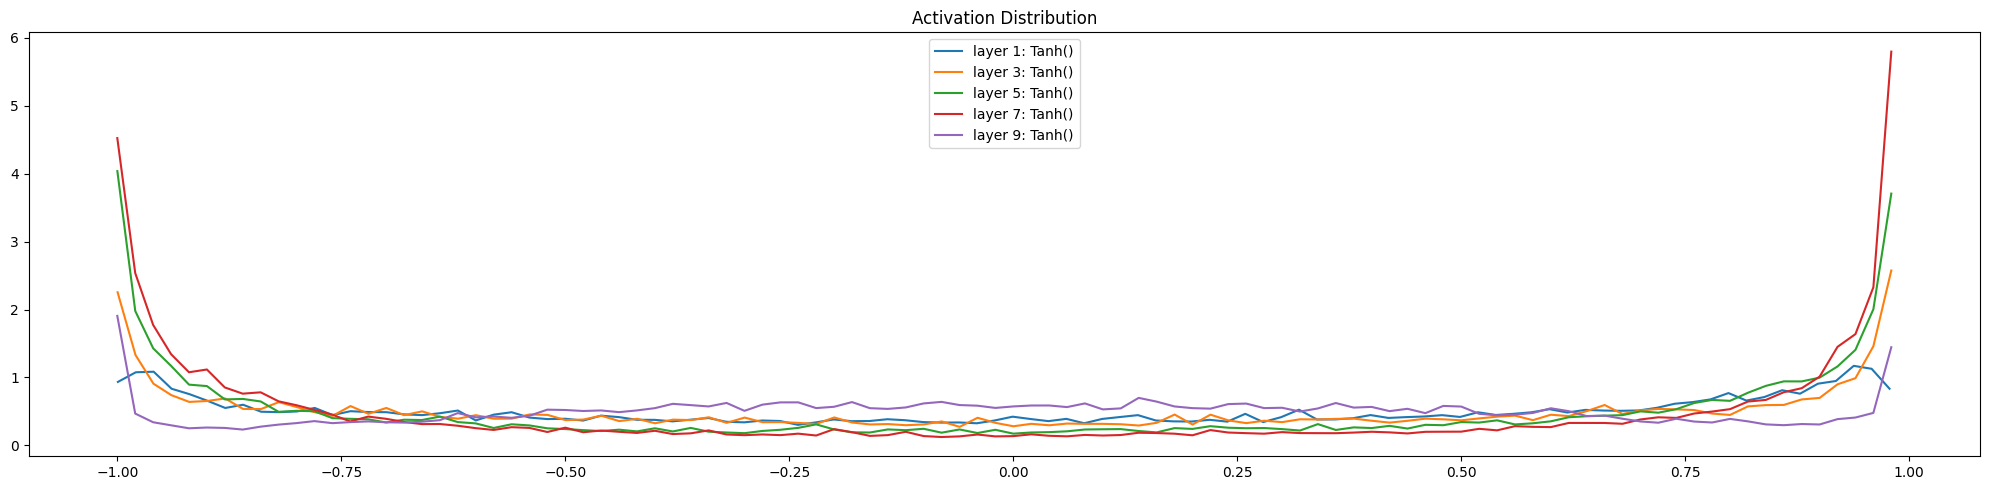

In [32]:
# Visualize Histograms
plt.figure(figsize=(20, 5))
legends: list[Any] = []

for idx, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.output
        print(
            f"layer {idx} ({layer}): mean {t.mean():+.2f}, std {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {idx}: {layer}")
plt.legend(legends)
plt.title("Activation Distribution")
plt.tight_layout()
plt.show()

### Interpretation Of The Chart

- The percentage of saturated activations, which are values close to ±1 (indicates that the activation function is outputting extreme values).
- The chart shows the distribution of activations for each `Tanh` layer.
- The x-axis represents the range of activation values.
- The y-axis represents the density of activations (i.e., how frequently certain activation values occur).
- Each line corresponds to the activation distribution of a different layer.

- Layer-wise Activation Distribution:
  - The plot shows how the activation values are distributed across different layers.
  - This can provide insights into how the neural network is learning and where activations might be saturated.

- Saturation:
  - Layers with higher saturation percentages have more activations near the extremes (±1).
  - This can be a sign of vanishing gradients in deeper layers, especially with the Tanh activation function.

- Mean and Standard Deviation:
  - The statistics printed for each layer help understand the central tendency and spread of activation values, which is crucial for diagnosing issues like exploding or vanishing gradients.

weight torch.Size([27, 10]) | mean -0.001315 | std 2.114747e-02 | grad:data ratio 1.199819e-01
weight torch.Size([30, 300]) | mean -0.000006 | std 1.555760e-03 | grad:data ratio 5.067065e-03
weight torch.Size([300, 300]) | mean -0.000002 | std 3.592779e-03 | grad:data ratio 3.691757e-02
weight torch.Size([300, 300]) | mean -0.000000 | std 2.722743e-03 | grad:data ratio 2.802919e-02
weight torch.Size([300, 300]) | mean -0.000005 | std 2.980776e-03 | grad:data ratio 3.071210e-02
weight torch.Size([300, 300]) | mean +0.000003 | std 3.181726e-03 | grad:data ratio 3.289247e-02
weight torch.Size([300, 27]) | mean +0.000000 | std 2.077891e-02 | grad:data ratio 7.406268e-01


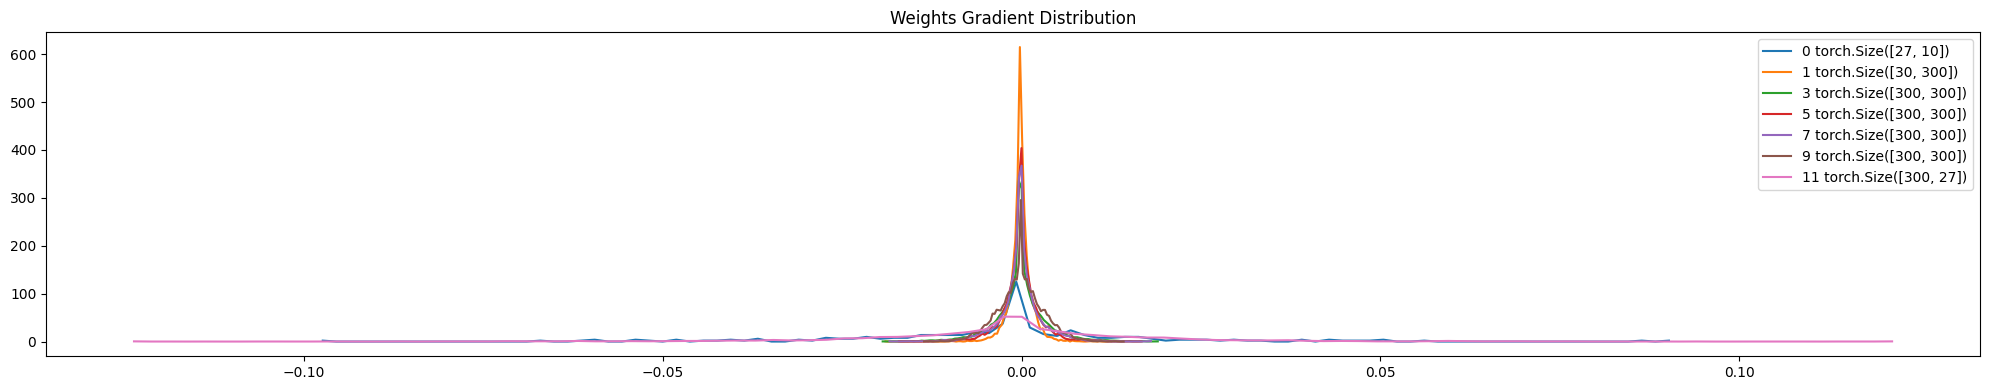

In [33]:
# Visualize histograms for parameters
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2 and t is not None:
        print(
            f"weight {p.shape} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std() / p.std():e}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {p.shape}")
plt.legend(legends)
plt.title("Weights Gradient Distribution")
plt.tight_layout()
plt.show()

### Interpretation

- Mean and Standard Deviation:
  - The statistics printed for each layer help understand the central tendency (mean) and spread (standard deviation) of gradient values.
  - The mean values being close to zero indicate that gradients are balanced around zero.
  - The small standard deviations suggest that the gradients are not exploding, which is a positive sign for the stability of the training process.

### Train The MLP

- Add Batchnorm

In [34]:
# Parameters
emb_dim: int = 10  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 300  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 140_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g) * 0.01  # Lookup table
W1: Tensor = torch.randn((M, n_nodes), generator=g) * 0.01
b1: Tensor = torch.randn(n_nodes, generator=g) * 0.01
# Initialize the weights and biases with very small random values.
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g) * 0.01  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g) * 0  # (27,)

layers: list[Any] = [
    Linear(in_features=M, out_features=n_nodes, bias=False),
    BatchNorm1d(dim=n_nodes),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_nodes, bias=False),
    BatchNorm1d(dim=n_nodes),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_nodes, bias=False),
    BatchNorm1d(dim=n_nodes),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_nodes, bias=False),
    BatchNorm1d(dim=n_nodes),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_nodes, bias=False),
    BatchNorm1d(dim=n_nodes),
    Tanh(),
    Linear(in_features=n_nodes, out_features=n_chars, bias=False),
    BatchNorm1d(dim=n_chars),
]

with torch.no_grad():
    # Make last layer less confident
    # layers[-1].weight *= 0.1  # Default: w/o BatchNorm
    layers[-1].gamma *= 0.1  # with BatchNorm

    # Apply gain to the other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # Scale the weights of all other linear layers by a gain factor.
            # layer.weight *= 5 / 3 # Default: w/o BatchNorm
            layer.weight *= 1.0  # with BatchNorm: No scaling

# Parameters Collection
parameters: list[Tensor] = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Total params: {sum(p.numel() for p in parameters):,}")

for p in parameters:
    p.requires_grad = True

Total params: 380,424


In [35]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))
    # X, y batch
    Xb, yb = X_train[idx], y_train[idx]

    # Forward pass
    # Step 1: Calculate the embeddings
    emb: Tensor = F.one_hot(Xb, num_classes=n_chars).float() @ C
    x: Tensor = emb.view(emb.shape[0], -1)  # Concatenate the embeddings

    # Step 2: Build The Hidden Layer
    for layer in layers:
        x: Tensor = layer(x)  # Logits: Apply the linear layer
    loss: Tensor = F.cross_entropy(x, yb)

    # Backward pass
    for p in parameters:
        # Reset gradients
        p.grad = None
    loss.backward()

    # learning rate decay
    learning_rate: float = (
        0.1 if epoch < 70_000 else (0.01 if epoch < 85_000 else 0.001)
    )

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch) % 10_000 == 0:
        print(f"Epoch: {epoch}/{epochs} | Loss: {loss.item():.4f}")

Epoch: 0/140000 | Loss: 3.2938
Epoch: 10000/140000 | Loss: 2.1282
Epoch: 20000/140000 | Loss: 1.8269
Epoch: 30000/140000 | Loss: 2.1610
Epoch: 40000/140000 | Loss: 2.0210
Epoch: 50000/140000 | Loss: 1.8326
Epoch: 60000/140000 | Loss: 2.0093
Epoch: 70000/140000 | Loss: 2.1069
Epoch: 80000/140000 | Loss: 2.1868
Epoch: 90000/140000 | Loss: 1.9358
Epoch: 100000/140000 | Loss: 2.3259
Epoch: 110000/140000 | Loss: 2.1946
Epoch: 120000/140000 | Loss: 2.0927
Epoch: 130000/140000 | Loss: 1.7870


In [36]:
calculate_loss_upd(X=X_train, y=y_train, num_classes=n_chars, training=True)
calculate_loss_upd(X=X_dev, y=y_dev, num_classes=n_chars, training=False)

Training loss: 1.9963
Validation loss: 2.0745


tensor(2.0745)

In [37]:
# sample from the model
g = torch.Generator().manual_seed(5)
n_names: int = 20

for _ in range(n_names):

    out: list[str] = []
    context: list[int] = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb: Tensor = C[torch.tensor([context])]  # (1,block_size,n_embd)
        x: Tensor = emb.view(emb.shape[0], -1)  # concatenate the vectors

        for layer in layers:
            x = layer(x)

        logits: Tensor = x
        probs: Tensor = F.softmax(logits, dim=1)
        # sample from the distribution
        idx: int = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [idx]
        out.append(idx)
        # If we sample the special '.' token, break
        if idx == 0:
            break

    # Decode and print the generated word
    print("".join(num_to_text.get(i) for i in out))

karyia.
kamaades.
zacca.
jaelihanvi.
hadyfp.
alaikna.
paioa.
medan.
huxcen.
ryleesek.
dicuctanylaniyah.
katchermelaa.
can.
slina.
novaya.
yohagton.
tainitayvessier.
harra.
jaxx.
marvin.
